In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
from acm.estimators.galaxy_clustering import DTVoid
from acm.utils import setup_logging
from pypower import mpi
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

setup_logging()

# read some random galaxy catalog
data_dir = '/pscratch/sd/e/epaillas/emc/hods/z0.5/yuan23_prior2/c000_ph000/'
data_fn = Path(data_dir) / 'hod3177.npy'
data = np.load(data_fn, allow_pickle=True).item()
boxsize = 2000.0
x = data['x']
y = data['y']
z_rsd = data['z_rsd']
data_positions = np.c_[x, y, z_rsd]

In [2]:
import multiprocessing
nthreads = multiprocessing.cpu_count()
print(f'Running notebook with {nthreads} threads') 

Running notebook with 256 threads


### Calculate DT spheres

In [3]:
def sample_function(void_cat, column = 'R'):
    limits = np.percentile(void_cat[column], np.linspace(0, 100, 7))
    toret = []
    for i in range(len(limits)-1):
        mask = (void_cat[column] > limits[i]) & (void_cat[column] < limits[i+1])
        try:
            toret.append(void_cat.loc[mask,['x', 'y', 'z', 'R', 'dtfe', 'sphericity']].values)
        except KeyError:
            toret.append(void_cat.loc[mask,['x', 'y', 'z', 'R']].values)
    return toret

In [4]:
# calculate density splits
dts = DTVoid(boxsize=[boxsize]*3)
dt_spheres = dts.compute_spheres(data_positions, full_catalog = True, sample_function = sample_function)


[000000.64]  05-16 07:45  DTVoid                       INFO     Initializing DTVoid.
==> Point density: 0.000499697 (h/Mpc)^3
==> Domain volume: 8e+09 (Mpc/h)^3
==> Mean free path: 12.6018 Mpc/h
==> Copy range: 48.5168 Mpc/h
==> Number of points: 3997577

Duplicating boundaries for periodic condition
==> Number of points: 4601750
==> Building Delaunay Triangulation.
==> Number of vertices: 4601750
==> Number of all cells: 30726585
==> Number of finite cells: 30725899
==> Computing DTFE
==> Copying voids and interpolating
    Done
[000093.05]  05-16 07:46  DTVoid                       INFO     Biggest void is of size 34.56395678219252 Mpc/h
[000093.66]  05-16 07:46  DTVoid                       INFO     Got DT spheres in total time 93.02049970626831 s


[000941.90]  05-16 08:00  matplotlib.legend            WARNING  No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
[000941.90]  05-16 08:00  matplotlib.legend            WARNING  No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
[000941.90]  05-16 08:00  matplotlib.legend            WARNING  No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
[000941.90]  05-16 08:00  matplotlib.legend            WARNING  No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


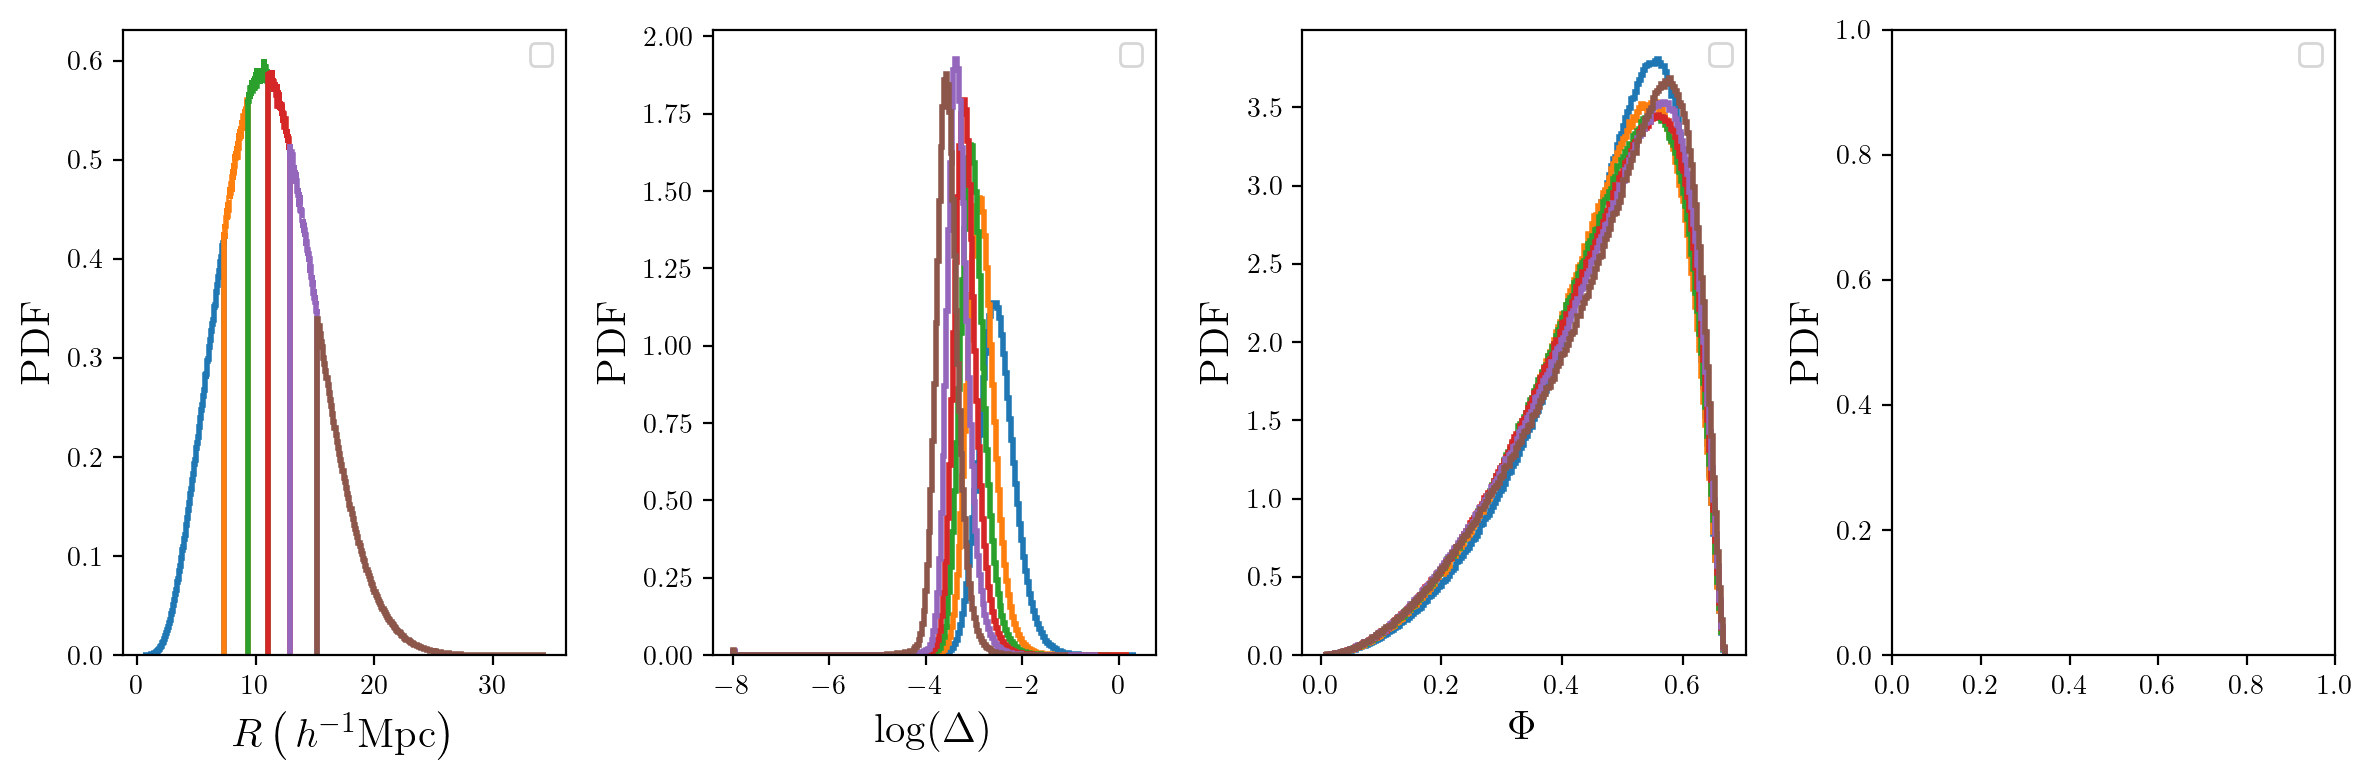

In [7]:
dts.plot_one_point()
plt.show()

### Calculate clustering in configuration space

[000969.28]  05-16 08:01  TwoPointCorrelationFunction  INFO     Using estimator <class 'pycorr.twopoint_estimator.NaturalTwoPointEstimator'>.
[000969.28]  05-16 08:01  TwoPointCorrelationFunction  INFO     Running cross-correlation.
[000969.28]  05-16 08:01  TwoPointCorrelationFunction  INFO     Computing two-point counts D1D2.
[000980.28]  05-16 08:01  TwoPointCorrelationFunction  INFO     Analytically computing two-point counts R1R2.
[000980.28]  05-16 08:01  TwoPointCorrelationFunction  INFO     Correlation function computed in elapsed time 11.00 s.
[000980.28]  05-16 08:01  TwoPointCorrelationFunction  INFO     Using estimator <class 'pycorr.twopoint_estimator.NaturalTwoPointEstimator'>.
[000980.28]  05-16 08:01  TwoPointCorrelationFunction  INFO     Running cross-correlation.
[000980.28]  05-16 08:01  TwoPointCorrelationFunction  INFO     Computing two-point counts D1D2.
[000991.28]  05-16 08:01  TwoPointCorrelationFunction  INFO     Analytically computing two-point counts R1R2.
[

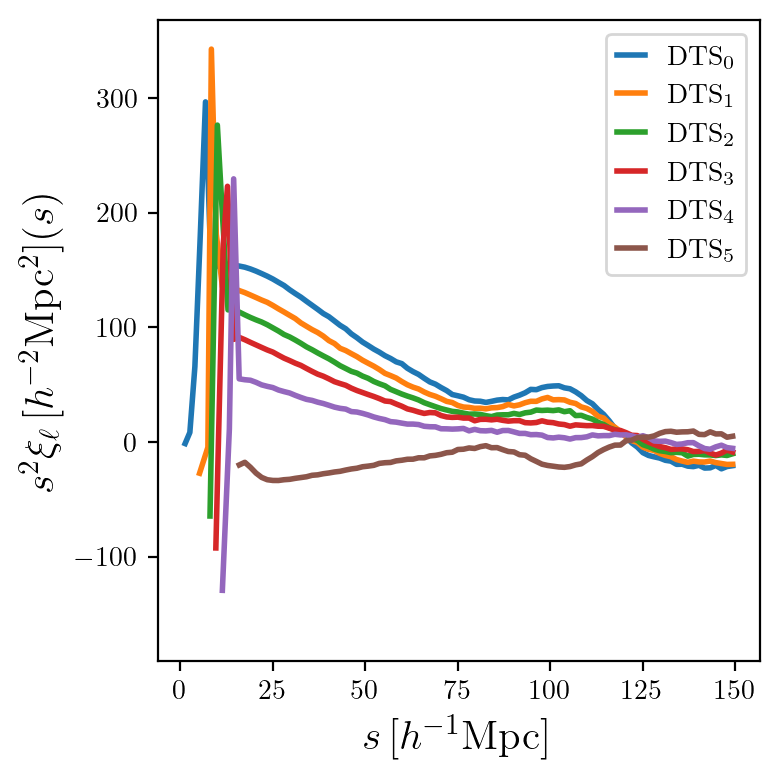

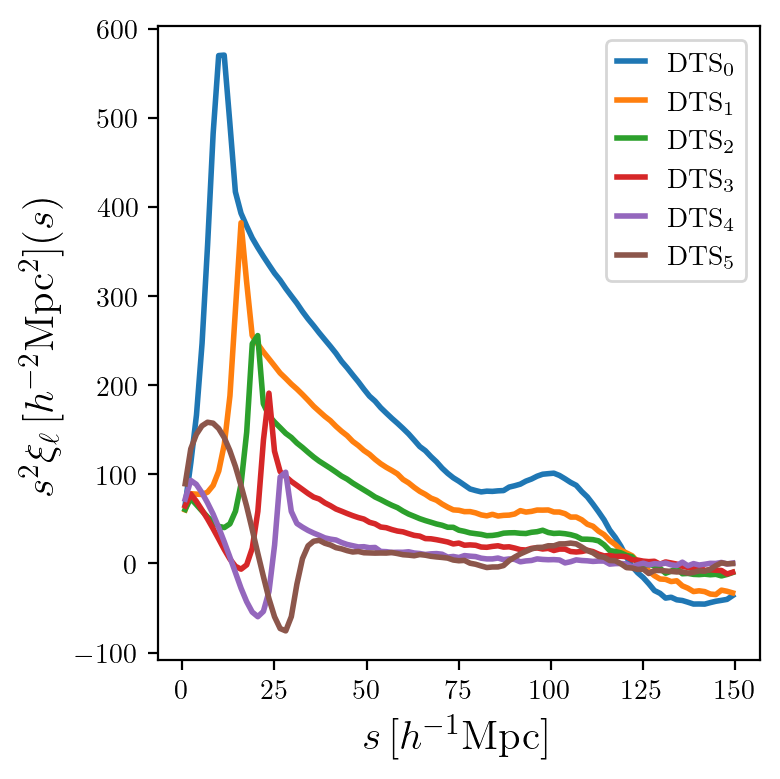

In [8]:
sedges = np.linspace(0, 150, 100)
muedges = np.linspace(-1, 1, 241)
dts.sample_data_correlation(data_positions, edges=(sedges, muedges), los='z', nthreads=nthreads)
dts.sample_correlation(edges=(sedges, muedges), los='z', nthreads=nthreads)
dts.plot_sample_data_correlation(ell=0)
dts.plot_sample_correlation(ell=0)
plt.show()

### Calculate clustering in Fourier space

[001081.94]  05-16 08:03  CatalogFFTPower              INFO     Painting catalog 1 to mesh CatalogMesh(nmesh=[256 256 256], boxsize=[2000. 2000. 2000.], boxcenter=[1000.00014101  999.99993896  999.99997232], dtype=float64).
[001081.98]  05-16 08:03  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 4455303.
[001083.56]  05-16 08:03  CatalogMesh                  INFO     Painted 4194304 out of 4455303 objects to mesh.
[001083.56]  05-16 08:03  CatalogMesh                  INFO     Slab 4194304 ~ 8388608 / 4455303.
[001083.74]  05-16 08:03  CatalogMesh                  INFO     Painted 4455303 out of 4455303 objects to mesh.
[001083.74]  05-16 08:03  CatalogMesh                  INFO     Running interlacing at order 2.
[001084.09]  05-16 08:03  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 4455303.
[001085.63]  05-16 08:03  CatalogMesh                  INFO     Painted 4194304 out of 4455303 objects to mesh.
[001085.64]  05-16 08:03  CatalogMesh                  INFO   

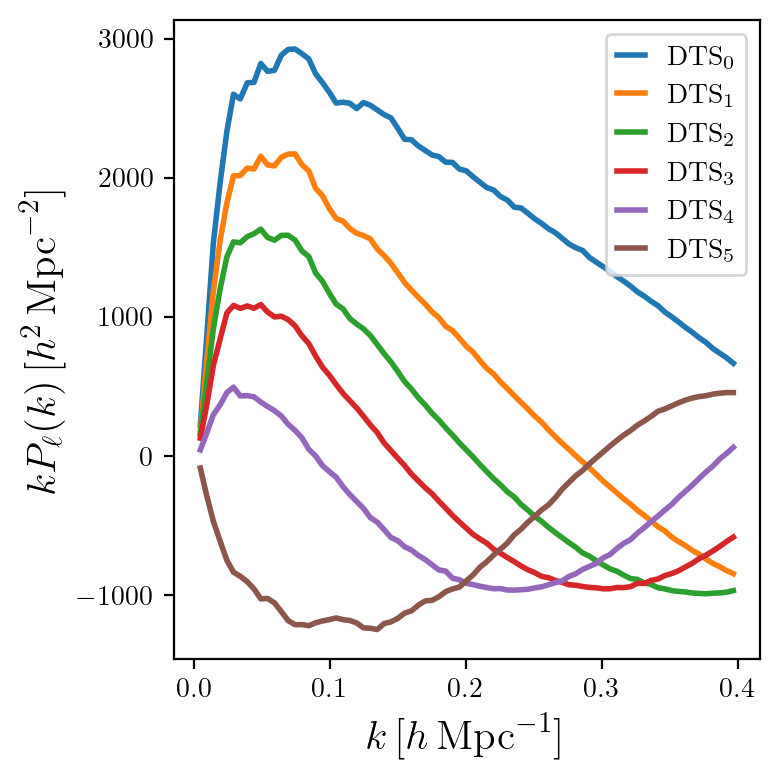

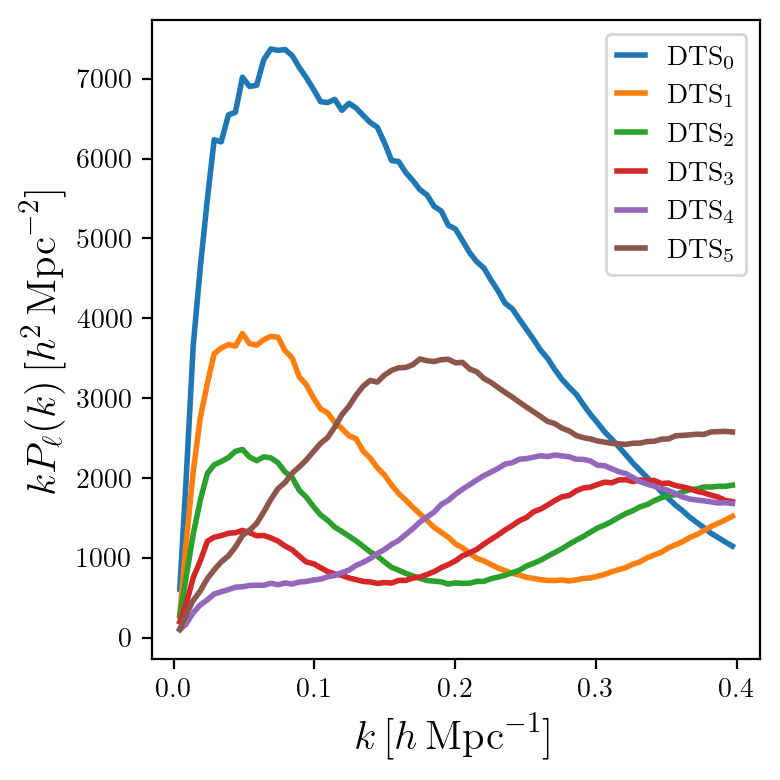

In [9]:
edges = np.linspace(0.001, 0.5, 100)
dts.sample_data_power(data_positions, edges=edges, los='z', nmesh=256, )
dts.sample_power(edges=edges, los='z', nmesh=256)
dts.plot_sample_data_power(ell=0)
dts.plot_sample_power(ell=0)
plt.show()

### Working with survey data

In [10]:
import fitsio
from cosmoprimo.fiducial import DESI
from pyrecon.utils import sky_to_cartesian
from astropy.table import Table, vstack
from scipy.interpolate import interp1d
import desimodel.footprint as foot
import numexpr as ne
setup_logging()
cosmo = DESI()
distance = cosmo.comoving_radial_distance

version = 'v1.2/blinded'
tracer = 'LRG'
zmin, zmax = 0.4, 0.6
region = 'NGC'
nrandoms = 5

# read data
#data_dir = f'/global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/iron/LSScats/{version}'
data_dir = "/global/cfs/cdirs/desi//survey/catalogs/Y1/mocks/SecondGenMocks/AbacusSummit/desipipe/v4_1/altmtl/2pt/"
data_fn = f"{data_dir}/mock0/recon_sm15_IFFT_recsym/{tracer}_{region}_clustering.dat.fits"
tiles = Table.read('/global/cfs/cdirs/desi/survey/catalogs/Y1/LSS/tiles-DARK.fits')
cosmo_cache = dict(r = cosmo.comoving_radial_distance(np.linspace(zmin, zmax, 10000)), z = np.linspace(zmin, zmax, 10000))
z_i = interp1d(cosmo_cache['r'], cosmo_cache['z'], kind='linear', fill_value="extrapolate")

def read_desi(filename, distance, zmin=0.45, zmax=0.6):
    """Read CMASS LSS catalogues."""
    data = fitsio.read(filename)
    mask = (data['Z'] > zmin) & (data['Z'] < zmax)
    ra = data[mask]['RA']
    dec = data[mask]['DEC']
    redshift = data[mask]['Z']
    dist = distance(redshift)
    try:
        weights = data[mask]['WEIGHT']
        
    except ValueError:
        weights = None
    positions = sky_to_cartesian(dist=dist, ra=ra, dec=dec)
    return positions, weights

def mask_column(voids, column, n_quantiles, distance, inverse = False, limits = None):
    toret = []
    mask = foot.is_point_in_desi(tiles, voids['RA'].values, voids['DEC'].values)
    voids = voids[mask]
    ra = voids['RA']
    dec = voids['DEC']
    redshift = voids['Z']
    dist = distance(redshift)
    voids.loc[:,['x', 'y', 'z']] =  sky_to_cartesian(dist=dist, ra=ra, dec=dec)
    if not inverse:
        if limits is None:
            limits = np.percentile(voids[column], np.linspace(0, 100, n_quantiles+1))
            
        for i in range(len(limits)-1):
            mask = (voids[column] >= limits[i]) & (voids[column] < limits[i+1])
            print(f"Selecting according to column {column} values in [{limits[i]:.1e}, {limits[i+1]:.1e}]")
            toret.append(voids.loc[mask,['x', 'y', 'z', 'R', 'dtfe', 'sphericity', "normed_dtfe"]].values)
    else:
        if limits is None:
            limits = np.percentile(voids[column]**-1, np.linspace(0, 100, n_quantiles+1))
        for i in range(len(limits)-1):
            mask = (voids[column]**-1 >= limits[i]) & (voids[column]**-1 < limits[i+1])
            print(f"Selecting according to column {column} values in [{limits[1]**-1:.1f}, {limits[0]**-1:1f}]")
            toret.append(voids.loc[mask,['x', 'y', 'z', 'R', 'dtfe', 'sphericity', "normed_dtfe"]].values)
        
    return toret, limits

def mask_void_outliers(voids, cap):
    #mask_r = voids['R'].values < 1000
    mask_r = voids['R'].values < np.percentile(voids['R'], 99.999)
    # NGC mask
    mask_ngc = (voids['RA'].values > 85) & (voids['RA'].values < 300)
    mask = mask_r & (mask_ngc if cap == 'NGC' else ~mask_ngc)
    return voids[mask]


def mask_redshift(tab, zmin, zmax, zpad):
    print("... redshift masking", flush=True)    
    z_mask = (tab['Z'] < (zmax+zpad)) & (tab['Z'] > (zmin-zpad))
    return tab[z_mask]


data_positions, data_weights = read_desi(distance=distance, filename=data_fn, zmin=zmin, zmax=zmax)

# read randoms
randoms_positions = []
randoms_weights = []
for i in range(nrandoms):
    randoms_dir = data_dir
    randoms_fn = f"{data_dir}/mock0/recon_sm15_IFFT_recsym/{tracer}_{region}_{i}_clustering.ran.fits"
    randoms_positions_i, randoms_weights_i = read_desi(distance=distance, filename=randoms_fn,
                                                       zmin=zmin, zmax=zmax)
    randoms_positions.append(randoms_positions_i)
    randoms_weights.append(randoms_weights_i)
randoms_positions = np.concatenate(randoms_positions)
randoms_weights = np.concatenate(randoms_weights)

[001182.46]  05-16 08:04  jax._src.xla_bridge          INFO     Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: CUDA
[001182.48]  05-16 08:04  jax._src.xla_bridge          INFO     Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


In [11]:
void_rand_dir = f"/global/cfs/cdirs/desi/users/dforero/projects/y1-voids/SecondGenMocks/EZmock/v1/ffa/"
void_ran_fn = f"{void_rand_dir}/recon_sm15_IFFT_recsym/{tracer}_{region}_{{}}_clustering.DTvoids.ran.fits"
void_randoms_positions = []
void_randoms_weights = []
def load_void_catalogs(void_dat_fns, cap, selection, distance, invert_selection, n_sel_bins, zmin, zmax, limits = None):
    void_dat = mask_void_outliers(vstack([Table.read(v) for v in void_dat_fns]).to_pandas(), cap)
    void_dat['sphericity'] = np.pi**(1/3) * (6 * void_dat['vol'])**(2/3) / void_dat['area']
    print(void_dat.columns)
    void_dat = mask_redshift(void_dat , zmin, zmax, 0)
    void_dat, limits = mask_column(void_dat, selection, n_sel_bins, distance, inverse = invert_selection, limits = limits)
    
    return void_dat, limits

void_randoms_positions, _ = load_void_catalogs([void_ran_fn.format(i) for i in range(nrandoms)], region, 'R', distance, False, 6, zmin, zmax)
    
nz_fn = f"/global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/EZmock/FFA/mock1/{tracer}_ffa_nz.txt"
nz_arr = np.loadtxt(nz_fn)

Index(['RA', 'DEC', 'Z', 'normed_dtfe', 'R', 'dtfe', 'vol', 'area',
       'sphericity'],
      dtype='object')
... redshift masking
Selecting according to column R values in [6.2e-01, 9.0e+00]
Selecting according to column R values in [9.0e+00, 1.2e+01]
Selecting according to column R values in [1.2e+01, 1.4e+01]
Selecting according to column R values in [1.4e+01, 1.6e+01]
Selecting according to column R values in [1.6e+01, 1.9e+01]
Selecting according to column R values in [1.9e+01, 7.4e+01]


In [12]:

def cartesian_to_sky(cols, interp):
    distance = ne.evaluate("sqrt(x**2 + y**2 + z**2)", local_dict = dict(x = cols['x'].values, y = cols['y'].values, z = cols['z'].values))
    cols['Z'] = interp(distance)
    cols['DEC'] = 90 - np.degrees((np.arccos(cols['z'].values / distance)))
    cols['RA'] = np.degrees(np.arctan2(cols['y'], cols['x']))
    cols['RA'].loc[cols['RA'] < 0] += 360
    return cols
def sample_function(void_cat, column = 'R'):
    void_cat = cartesian_to_sky(void_cat, z_i)
    mask = foot.is_point_in_desi(tiles, void_cat['RA'].values, void_cat['DEC'].values) & (void_cat['Z'].values > zmin) & (void_cat['Z'].values < zmax)
    void_cat['normed_dtfe'] = void_cat['dtfe'] / np.interp(void_cat['Z'].values, nz_arr[:,0] , nz_arr[:,3])
    mask_ngc = (void_cat['RA'].values > 85) & (void_cat['RA'].values < 300)
    mask_r = void_cat['R'].values < np.percentile(void_cat['R'], 98)
    limits = np.percentile(void_cat[column], np.linspace(0, 100, 7))
    toret = []
    for i in range(len(limits)-1):
        mask = (void_cat[column] > limits[i]) & (void_cat[column] < limits[i+1]) & mask_ngc & mask_r
        try:
            toret.append(void_cat.loc[mask,['x', 'y', 'z', 'R', 'dtfe', 'sphericity', "normed_dtfe"]].values)
        except KeyError:
            toret.append(void_cat.loc[mask,['x', 'y', 'z', 'R']].values)
    return toret

In [13]:
dts = DTVoid(void_randoms = void_randoms_positions)
dt_spheres = dts.compute_spheres(data_positions, full_catalog = True, sample_function = sample_function)

[000059.80]  05-16 08:05  DTVoid                       INFO     Initializing DTVoid.
[000059.80]  05-16 08:05  DTVoid                       INFO     No copy_range required with natively periodic DT.
==> Number of points: 355934
==> Building Delaunay Triangulation.
==> Number of vertices: 355934
==> Number of all cells: 2371926
==> Number of finite cells: 2369122
==> Computing DTFE
==> Copying voids and interpolating
    Done
[000066.28]  05-16 08:05  DTVoid                       INFO     Got DT spheres in total time 6.487051963806152 s


[000068.78]  05-16 08:05  matplotlib.legend            WARNING  No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
[000068.78]  05-16 08:05  matplotlib.legend            WARNING  No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
[000068.78]  05-16 08:05  matplotlib.legend            WARNING  No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
[000068.78]  05-16 08:05  matplotlib.legend            WARNING  No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
[000068.78]  05-16 08:05  matplotlib.legend            WARNING  No artists with labels found to put in legend.  Note

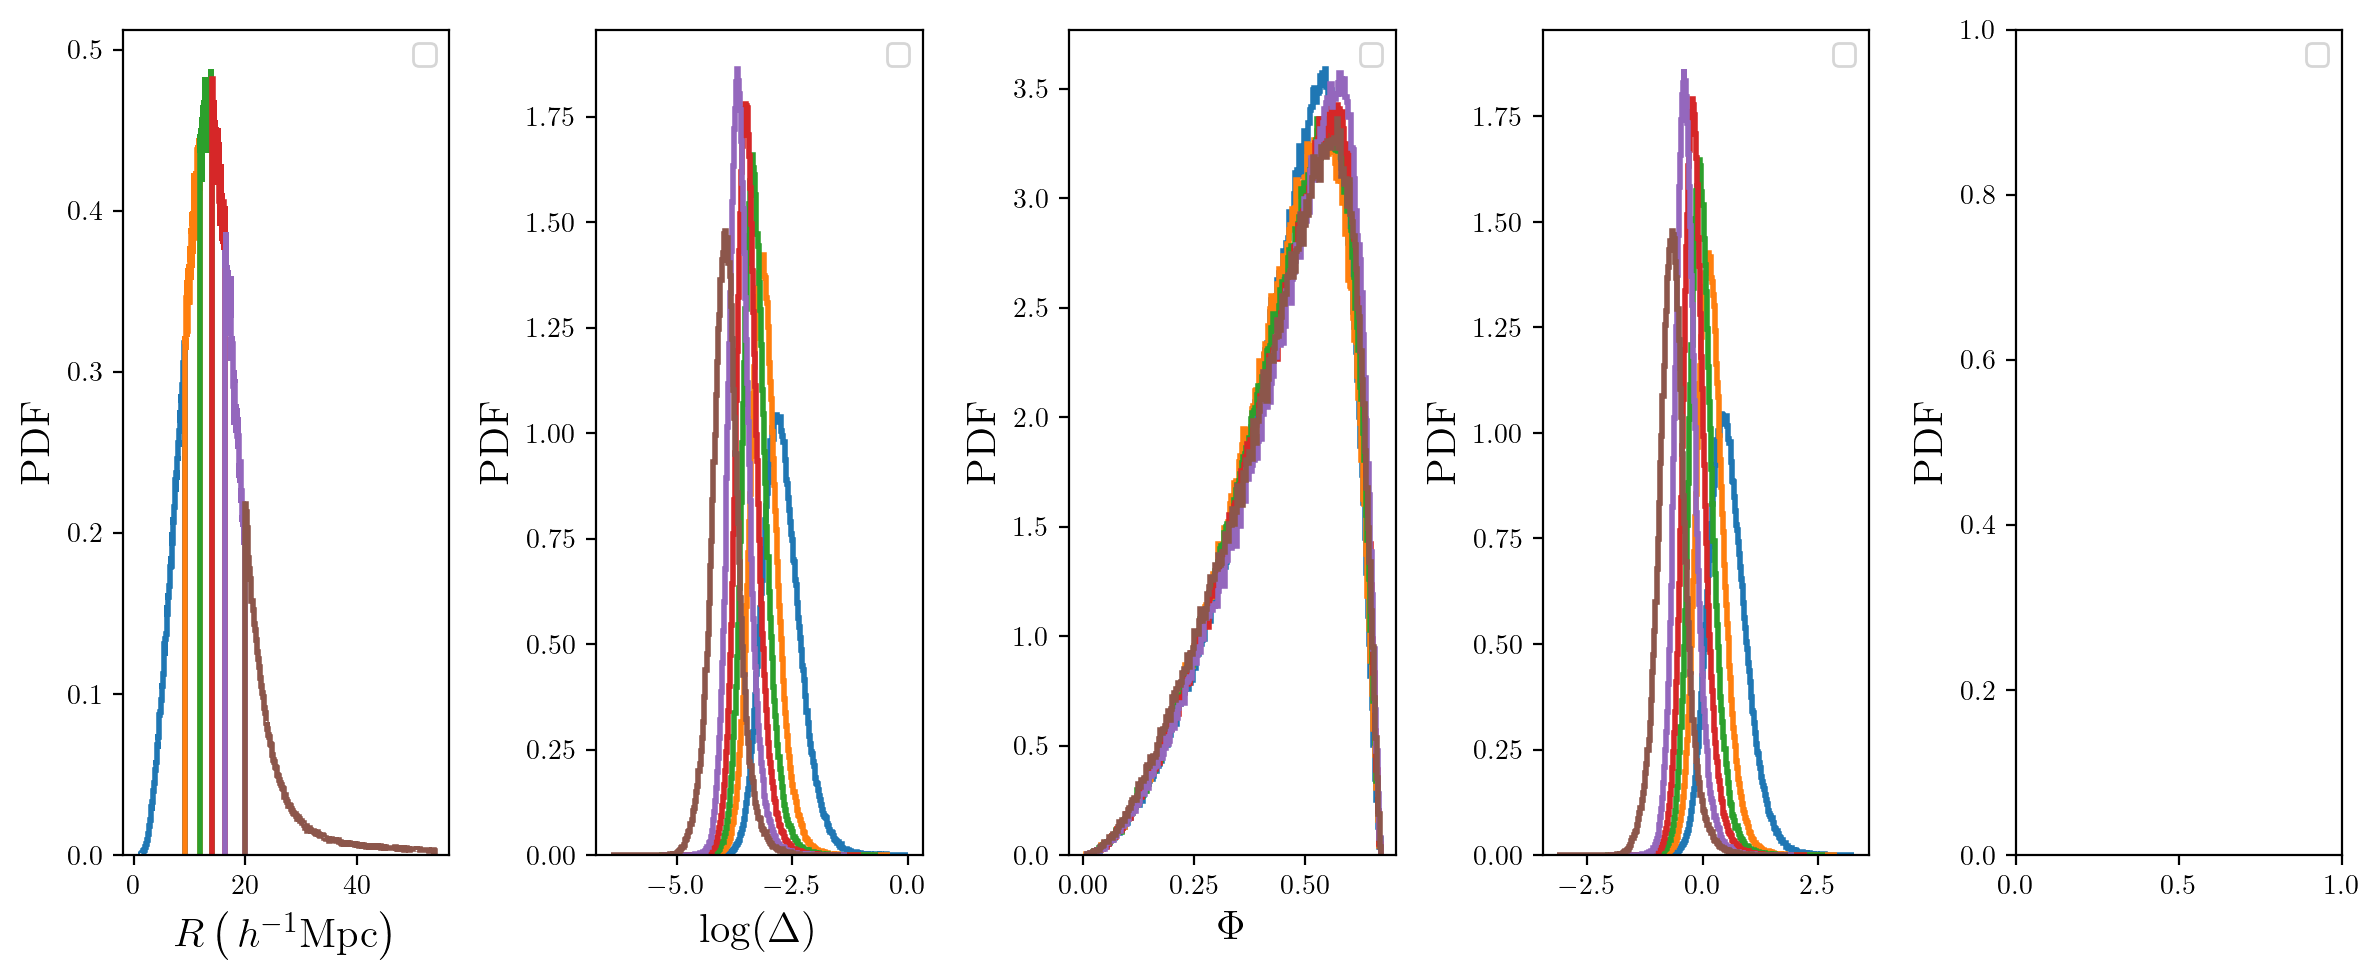

In [14]:
dts.plot_one_point()
plt.show()

[000069.88]  05-16 08:05  TwoPointCorrelationFunction  INFO     Using estimator <class 'pycorr.twopoint_estimator.LandySzalayTwoPointEstimator'>.
[000069.88]  05-16 08:05  TwoPointCorrelationFunction  INFO     Running cross-correlation.
[000069.88]  05-16 08:05  TwoPointCorrelationFunction  INFO     Computing two-point counts D1D2.
[000071.21]  05-16 08:05  TwoPointCorrelationFunction  INFO     Computing two-point counts D1R2.
[000092.04]  05-16 08:06  TwoPointCorrelationFunction  INFO     Computing two-point counts R1D2.
[000100.11]  05-16 08:06  TwoPointCorrelationFunction  INFO     Computing two-point counts R1R2.
[000250.67]  05-16 08:08  TwoPointCorrelationFunction  INFO     Correlation function computed in elapsed time 180.79 s.
[000250.67]  05-16 08:08  TwoPointCorrelationFunction  INFO     Using estimator <class 'pycorr.twopoint_estimator.LandySzalayTwoPointEstimator'>.
[000250.67]  05-16 08:08  TwoPointCorrelationFunction  INFO     Running cross-correlation.
[000250.67]  05-16

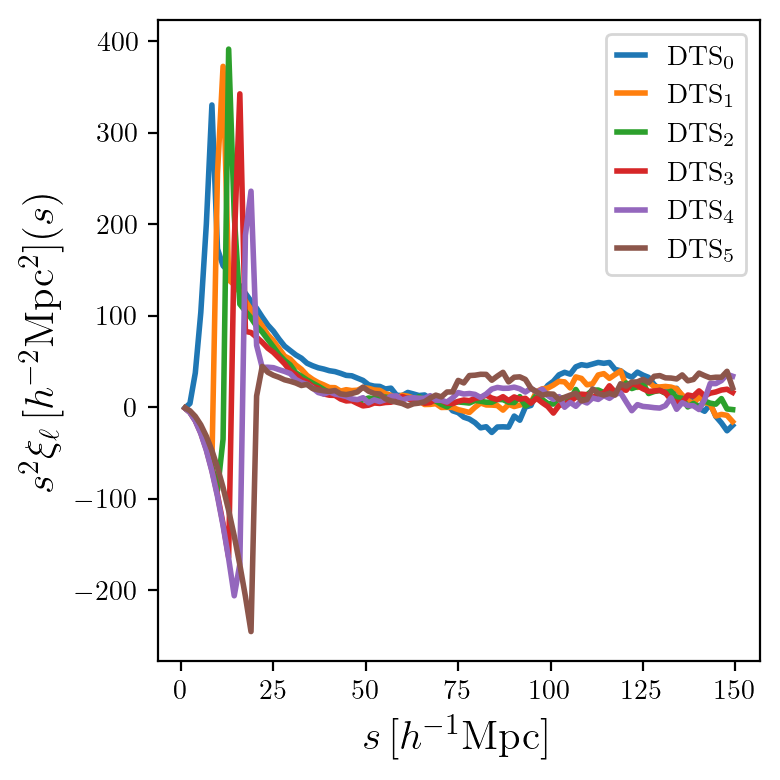

In [15]:
sedges = np.linspace(0, 150, 100)
muedges = np.linspace(-1, 1, 241)
dts.sample_data_correlation(data_positions=data_positions, randoms_positions=randoms_positions,
                             data_weights=data_weights, randoms_weights=randoms_weights,
                             edges=(sedges, muedges), los='midpoint', nthreads=nthreads)

dts.plot_sample_data_correlation(ell=0)
plt.show()